In [1]:
#!pip install textblob
#!pip install tweepy
#!pip install gzip

import numpy as np
import pandas as pd
import wordcloud
import matplotlib.pyplot as plt
import os
import gzip
import json
%matplotlib inline
from time import perf_counter

import textblob
import tweepy
import nltk
nltk.download("opinion_lexicon")
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import opinion_lexicon

from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from string import punctuation

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report

from xgboost.sklearn import XGBClassifier

[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     C:\Users\nrohi\AppData\Roaming\nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nrohi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nrohi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\nrohi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Useful Functions

In [2]:
def my_random_forest_report(cv_results, n_top=3):
    '''
    cv_results: Takes the randomForest_object.cv_results_
    n_top: No of top results to be displayed
    
    Description:
        randomForest_object.cv_results_ gives a long list of attributes.
        This report function retuns only the top n from results from that big list in a graspable format.
    '''
    for i in range(1,n_top+1,1):
        rank_indices = np.flatnonzero(cv_results["rank_test_score"]==i)
        # the following loop is made because there can be one or more elements of the same rank
        for rank_index in rank_indices:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.4f} (std: {1:.4f})".format(
                cv_results["mean_test_score"][rank_index],
                cv_results["std_test_score"][rank_index]))
            print("Parameters: {0}".format(cv_results["params"][rank_index]))
            print("")

## Data Explorations

In [3]:
lemma = WordNetLemmatizer()
stp_wds = set(stopwords.words("english")+list(punctuation))

# stp_wds_pos = stp_wds.union(set(opinion_lexicon.positive()))
# stp_wds_neg = stp_wds.union(set(opinion_lexicon.negative()))
stp_wds

{'!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'need

In [3]:
tweets = pd.read_csv(r"C:\Users\nrohi\Desktop\DataSets\Twitter Data Set\Sentiment Analysis Dataset.csv")
tweets = tweets[["SentimentText", "Sentiment"]]
tweets_p, tweets_n = tweets[tweets["Sentiment"] == 1], tweets[tweets["Sentiment"] == 0]
tweets

,SentimentText,Sentiment
0,is so sad for my APL frie...,0
1,I missed the New Moon trail...,0
2,omg its already 7:30 :O,1
3,.. Omgaga. Im sooo im gunna CRy. I'...,0
4,i think mi bf is cheating on me!!! ...,0
...,...,...
1578573,Zzzzzz.... Finally! Night tweeters!,1
1578574,"Zzzzzzz, sleep well people",1
1578575,ZzzZzZzzzZ... wait no I have homework.,0
1578576,"ZzZzzzZZZZzzz meh, what am I doing up again?",0


In [4]:
np.sum(tweets["Sentiment"])/tweets.shape[0]

0.5005466945567466

In [5]:
t_pos_nos = np.random.randint(low = 0, high = tweets_p.shape[0], size = 25000)
t_neg_nos = np.random.randint(low = 0, high = tweets_n.shape[0], size = 25000)

tweets_p = tweets_p.iloc[t_pos_nos]
tweets_n = tweets_n.iloc[t_neg_nos]

t_tweet_p, v_tweet_p =  train_test_split(tweets_p, test_size = 5000)
t_tweet_n, v_tweet_n =  train_test_split(tweets_n, test_size = 5000)

tweets_train =  pd.concat([t_tweet_p, t_tweet_n], axis = 0, ignore_index = True)
tweets_train = tweets_train.sample(frac=1, random_state = 123).reset_index(drop=True)

tweets_val =  pd.concat([v_tweet_p, v_tweet_n], axis = 0, ignore_index = True)
tweets_val = tweets_val.sample(frac=1, random_state = 123).reset_index(drop=True)

In [6]:
tweets = pd.concat([tweets_train, tweets_val], axis = 0, ignore_index = True)

In [8]:
all_text = " ".join(list(tweets["SentimentText"]))
pos_text = " ".join(list(tweets.loc[tweets["Sentiment"] == 1, ["SentimentText"]]["SentimentText"]))
neg_text = " ".join(list(tweets.loc[tweets["Sentiment"] == 0, ["SentimentText"]]["SentimentText"]))

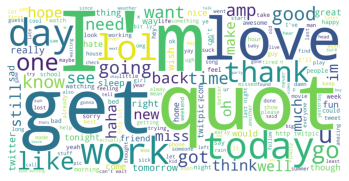

In [9]:
wd = wordcloud.WordCloud(stopwords = stp_wds, background_color = "white", width = 4000, height = 2000).generate(all_text)

plt.imshow(wd)
plt.axis("off")
plt.show()

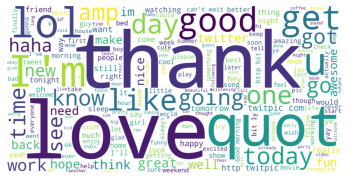

In [10]:
wd = wordcloud.WordCloud(stopwords = stp_wds, background_color = "white", width = 4000, height = 2000).generate(pos_text)

plt.imshow(wd)
plt.axis("off")
plt.show()

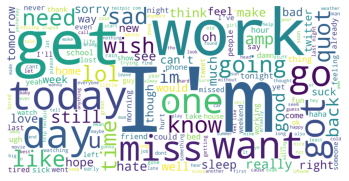

In [11]:
wd = wordcloud.WordCloud(stopwords = stp_wds, background_color = "white", width = 4000, height = 2000).generate(neg_text)

plt.imshow(wd)
plt.axis("off")
plt.show()

## Text Cleaning

In [3]:
def get_lem(text):
    text = text.lower()
    words = word_tokenize(text)
    words_stop = []
    for word in words:
        if word in stp_wds: continue
        words_stop.append(word)
    return [lemma.lemmatize(word) for word in words_stop]

def pos_neg(lemm_list):
    pos_words = []
    neg_words = []
    for word in lemm_list:
        if word in opinion_lexicon.negative(): neg_words.append(word)
        if word in opinion_lexicon.positive(): pos_words.append(word)
    return (pos_words, neg_words)

In [13]:
tweets[["SentimentText"]]

,SentimentText
0,@MontyRules naah I wish fella!! Got VAT return...
1,@erika_lukanov I've gotta work at 5 AM My ne...
2,"@edjames1 I know you,ve been meat-free (allege..."
3,@Kit_Kat1990 I'm so annoyed coz I wanned to ru...
4,@twitter are you guys having db replication is...
...,...
49995,Black people let's do BETTER..it's never that ...
49996,@wanaTheGreat We just loved it. It should sti...
49997,@weblivz i guess son trumps over daughter in law
49998,Yummy...dairy queen


## Lexicon based method

In [14]:
t_f_start = perf_counter()

senti_pred = []
for i in list(tweets_val["SentimentText"]):

    this = pos_neg(get_lem(i))
    no_pos, no_neg = len(this[0]), len(this[1])
    if no_pos + no_neg > 0: 
        if((no_pos - no_neg)/(no_pos + no_neg)) >= 0: senti_pred.append(1)
        else: senti_pred.append(0)
    else: 
        senti_pred.append(1)


t_f_stop = perf_counter()
print("Elapsed time during the whole program in seconds:", t_f_stop-t_f_start)

Elapsed time during the whole program in seconds: 1161.325561


In [15]:
roc_auc_score(tweets_val["Sentiment"],senti_pred), accuracy_score(tweets_val["Sentiment"],senti_pred)

(0.632, 0.632)

In [16]:
print(classification_report(tweets_val["Sentiment"],senti_pred))
print("Accuracy of the model : ", accuracy_score(tweets_val["Sentiment"],senti_pred));

              precision    recall  f1-score   support

           0       0.78      0.37      0.50      5000
           1       0.59      0.89      0.71      5000

    accuracy                           0.63     10000
   macro avg       0.68      0.63      0.60     10000
weighted avg       0.68      0.63      0.60     10000

Accuracy of the model :  0.632


In [18]:
temp = get_lem(all_text)
len(temp)

421421

In [19]:
countv = CountVectorizer(analyzer = get_lem, min_df = 0.00005, max_df = 0.95)

In [20]:
t_countv_start = perf_counter()

countv.fit(tweets_train["SentimentText"])
tweets_train_countv = countv.transform(tweets_train["SentimentText"])
tweets_val_countv = countv.transform(tweets_val["SentimentText"])

t_countv_stop = perf_counter()
print("Elapsed time for count vectorizer training in seconds", t_countv_stop-t_countv_start)

Elapsed time for count vectorizer training in seconds 16.70342199999982


In [21]:
len(countv.vocabulary_)

13343

In [22]:
np.sum(list(countv.vocabulary_.values()))

89011153

## Logistic Regression

In [23]:
t_lr_start = perf_counter()

lr_model_tw = LogisticRegression(class_weight="balanced")
param_lr_model_tw = {"C": np.concatenate([np.linspace(0.0001, 0.001, 10), np.linspace(0.001, 0, 100), np.linspace(0, 100, 100)])
                      }

grid_search_lr_model_tw = GridSearchCV(estimator=lr_model_tw, param_grid=param_lr_model_tw,
                                       verbose = 1, n_jobs = 6,
                                       cv=10, scoring="roc_auc")
grid_search_lr_model_tw.fit(X=tweets_train_countv, y=tweets_train["Sentiment"])

t_lr_stop = perf_counter()
print("Elapsed time for Logistic Regression Grid Search in seconds:", t_lr_stop-t_lr_start)

Fitting 10 folds for each of 210 candidates, totalling 2100 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    2.2s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:    5.3s
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:   10.7s
[Parallel(n_jobs=6)]: Done 788 tasks      | elapsed:   17.4s
[Parallel(n_jobs=6)]: Done 1340 tasks      | elapsed:   56.1s
[Parallel(n_jobs=6)]: Done 1890 tasks      | elapsed:  2.2min
[Parallel(n_jobs=6)]: Done 2100 out of 2100 | elapsed:  2.7min finished


Elapsed time for Logistic Regression Grid Search in seconds: 163.22157089999996


E:\Software\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [24]:
my_random_forest_report(grid_search_lr_model_tw.cv_results_, n_top = 10)

Model with rank: 1
Mean validation score: 0.8247 (std: 0.0055)
Parameters: {'C': 1.0101010101010102}

Model with rank: 2
Mean validation score: 0.8186 (std: 0.0058)
Parameters: {'C': 2.0202020202020203}

Model with rank: 3
Mean validation score: 0.8141 (std: 0.0061)
Parameters: {'C': 3.0303030303030303}

Model with rank: 4
Mean validation score: 0.8106 (std: 0.0061)
Parameters: {'C': 4.040404040404041}

Model with rank: 5
Mean validation score: 0.8081 (std: 0.0062)
Parameters: {'C': 5.050505050505051}

Model with rank: 6
Mean validation score: 0.8059 (std: 0.0061)
Parameters: {'C': 6.0606060606060606}

Model with rank: 7
Mean validation score: 0.8037 (std: 0.0067)
Parameters: {'C': 7.070707070707071}

Model with rank: 8
Mean validation score: 0.8025 (std: 0.0063)
Parameters: {'C': 8.080808080808081}

Model with rank: 9
Mean validation score: 0.8012 (std: 0.0057)
Parameters: {'C': 9.090909090909092}

Model with rank: 10
Mean validation score: 0.8002 (std: 0.0057)
Parameters: {'C': 10.10

In [25]:
lr = LogisticRegression(class_weight = "balanced", C = 1.0101010101010102)

In [26]:
t_lr_start = perf_counter()

lr.fit(tweets_train_countv, tweets_train["Sentiment"])

t_lr_stop = perf_counter()
print("Elapsed time for Logistic Regression training in seconds:", t_lr_stop-t_lr_start)

Elapsed time for Logistic Regression training in seconds: 0.4366714000000229


E:\Software\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [27]:
t_lr_start = perf_counter()

lr_pred = lr.predict(tweets_val_countv)

t_lr_stop = perf_counter()
print("Elapsed time for Logistic Regression predictions in seconds:", t_lr_stop-t_lr_start)

Elapsed time for Logistic Regression predictions in seconds: 0.0008368999999674998


In [28]:
roc_auc_score(tweets_val["Sentiment"], lr_pred), accuracy_score(tweets_val["Sentiment"], lr_pred)

(0.7162999999999999, 0.7163)

## Naive-Bayes

In [30]:
t_nb_start = perf_counter()

nb_model_tw = MultinomialNB()
param_nb_model_tw = {"alpha": np.concatenate([np.linspace(0.0001, 0.001, 10), np.linspace(0.001, 0, 100), np.linspace(0, 100, 100)])
                      }

random_search_nb_model_tw = RandomizedSearchCV(estimator=nb_model_tw, param_distributions=param_nb_model_tw,
                                               verbose = 1, n_jobs = 6,
                                               n_iter = 80, cv=10, scoring="roc_auc")
random_search_nb_model_tw.fit(X=tweets_train_countv, y=tweets_train["Sentiment"])

t_nb_stop = perf_counter()
print("Elapsed time for Naive Bayes Randomized Search in seconds:", t_nb_stop-t_nb_start)

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Fitting 10 folds for each of 80 candidates, totalling 800 fits


[Parallel(n_jobs=6)]: Done 100 tasks      | elapsed:    0.3s


Elapsed time for Naive Bayes Randomized Search in seconds: 2.186154100000067


[Parallel(n_jobs=6)]: Done 800 out of 800 | elapsed:    2.0s finished


In [31]:
my_random_forest_report(random_search_nb_model_tw.cv_results_, n_top = 10)

Model with rank: 1
Mean validation score: 0.8277 (std: 0.0050)
Parameters: {'alpha': 3.0303030303030303}

Model with rank: 2
Mean validation score: 0.8277 (std: 0.0048)
Parameters: {'alpha': 5.050505050505051}

Model with rank: 3
Mean validation score: 0.8270 (std: 0.0046)
Parameters: {'alpha': 7.070707070707071}

Model with rank: 4
Mean validation score: 0.8268 (std: 0.0052)
Parameters: {'alpha': 2.0202020202020203}

Model with rank: 5
Mean validation score: 0.8265 (std: 0.0046)
Parameters: {'alpha': 8.080808080808081}

Model with rank: 6
Mean validation score: 0.8251 (std: 0.0045)
Parameters: {'alpha': 11.111111111111112}

Model with rank: 7
Mean validation score: 0.8245 (std: 0.0045)
Parameters: {'alpha': 12.121212121212121}

Model with rank: 8
Mean validation score: 0.8236 (std: 0.0044)
Parameters: {'alpha': 14.141414141414142}

Model with rank: 9
Mean validation score: 0.8222 (std: 0.0045)
Parameters: {'alpha': 17.171717171717173}

Model with rank: 10
Mean validation score: 0.8213

In [32]:
mnb = MultinomialNB(alpha = 5.050505050505051)

In [33]:
t_nb_start = perf_counter()

mnb.fit(tweets_train_countv, tweets_train["Sentiment"])

t_nb_stop = perf_counter()
print("Elapsed time for Naive Bayes training in seconds:", t_nb_stop-t_nb_start)

Elapsed time for Naive Bayes training in seconds: 0.006735499999876993


In [34]:
t_nb_start = perf_counter()

mnb_pred = mnb.predict(tweets_val_countv)

t_nb_stop = perf_counter()
print("Elapsed time for Naive Bayes predictions in seconds:", t_nb_stop-t_nb_start)

Elapsed time for Naive Bayes predictions in seconds: 0.0017992999999023596


In [64]:
roc_auc_score(tweets_val["Sentiment"], mnb_pred), accuracy_score(tweets_val["Sentiment"], mnb_pred)

(0.7426999999999999, 0.7427)

In [35]:
print(classification_report(tweets_val["Sentiment"],mnb_pred))
print("Accuracy of the model : ", accuracy_score(tweets_val["Sentiment"], mnb_pred));

              precision    recall  f1-score   support

           0       0.73      0.78      0.75      5000
           1       0.76      0.70      0.73      5000

    accuracy                           0.74     10000
   macro avg       0.74      0.74      0.74     10000
weighted avg       0.74      0.74      0.74     10000

Accuracy of the model :  0.7427


## SVM

In [ ]:
t_svm_start = perf_counter()

svm_model_tw = SVC()
param_svm_model_tw = {"C": [0.01, 0.1, 1, 10, 100, 1000], 
                     "kernel" : ["rbf", "sigmoid", "linear"]
                      }

grid_search_svm_model_tw = GridSearchCV(estimator=svm_model_tw, param_grid=param_svm_model_tw,
                                       verbose = 1, n_jobs = 6,
                                       cv=10, scoring="roc_auc")
grid_search_svm_model_tw.fit(X=tweets_train_countv, y=tweets_train["Sentiment"])

t_svm_stop = perf_counter()
print("Elapsed time for SVM Grid Search in seconds:", t_svm_stop-t_svm_start)

Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed: 17.1min


In [ ]:
my_random_forest_report(grid_search_svm_model_tw.cv_results_, n_top = 10)

In [36]:
suppor_vect = SVC()

In [37]:
t_svm_start = perf_counter()

suppor_vect.fit(tweets_train_countv, tweets_train["Sentiment"])

t_svm_stop = perf_counter()
print("Elapsed time for SVM training in seconds:", t_svm_stop-t_svm_start)

Elapsed time for SVM training in seconds: 241.5591611000002


In [38]:
t_svm_start = perf_counter()

suppor_vect_pred = suppor_vect.predict(tweets_val_countv)

t_svm_stop = perf_counter()
print("Elapsed time for SVM predictions in seconds:", t_svm_stop-t_svm_start)

Elapsed time for SVM predictions in seconds: 20.225959600000124


In [39]:
roc_auc_score(tweets_val["Sentiment"], suppor_vect_pred), accuracy_score(tweets_val["Sentiment"], suppor_vect_pred)

(0.7526999999999999, 0.7527)

In [40]:
print(classification_report(tweets_val["Sentiment"], suppor_vect_pred))
print("Accuracy of the model : ", accuracy_score(tweets_val["Sentiment"], suppor_vect_pred));

              precision    recall  f1-score   support

           0       0.77      0.73      0.75      5000
           1       0.74      0.78      0.76      5000

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000

Accuracy of the model :  0.7527


## XGBoost

In [35]:
t_xgb_start = perf_counter()

xgb_model_tw = XGBClassifier(use_label_encoder = False,
                               objective="binary:logistic",
                               eval_metric = "logloss",
                                n_jobs =  6, verbosity = 1)

param_xgb_model_tw = {"n_estimators": [350, 500, 750, 1000],
                        "max_depth": [1,2,4,6],
                        'learning_rate': [0.01,0.05,0.1,0.5, 0.9],
                        "subsample" : [0.6, 0.8, 0.95],
                        "gamma": [0.01, 0.1, 1, 10, 100],
                      }

random_search_xgb_model_tw = RandomizedSearchCV(estimator=xgb_model_tw, param_distributions=param_xgb_model_tw,
                                               n_iter = 80, cv=10, scoring="roc_auc")
random_search_xgb_model_tw.fit(X=tweets_train_countv, y=tweets_train["Sentiment"])

t_xgb_stop = perf_counter()
print("Elapsed time for XGBoost Randomized Search in seconds:", t_xgb_stop-t_xgb_start)

Elapsed time for XGBoost Randomized Search in seconds: 8067.539665099999


In [36]:
my_random_forest_report(random_search_xgb_model_tw.cv_results_, n_top = 10)

Model with rank: 1
Mean validation score: 0.8223 (std: 0.0045)
Parameters: {'subsample': 0.95, 'n_estimators': 1000, 'max_depth': 6, 'learning_rate': 0.05, 'gamma': 1}

Model with rank: 2
Mean validation score: 0.8217 (std: 0.0035)
Parameters: {'subsample': 0.8, 'n_estimators': 1000, 'max_depth': 1, 'learning_rate': 0.5, 'gamma': 0.1}

Model with rank: 3
Mean validation score: 0.8197 (std: 0.0051)
Parameters: {'subsample': 0.95, 'n_estimators': 750, 'max_depth': 2, 'learning_rate': 0.9, 'gamma': 0.1}

Model with rank: 4
Mean validation score: 0.8195 (std: 0.0041)
Parameters: {'subsample': 0.6, 'n_estimators': 350, 'max_depth': 4, 'learning_rate': 0.5, 'gamma': 0.01}

Model with rank: 5
Mean validation score: 0.8186 (std: 0.0045)
Parameters: {'subsample': 0.6, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.5, 'gamma': 1}

Model with rank: 6
Mean validation score: 0.8179 (std: 0.0044)
Parameters: {'subsample': 0.8, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.5, 'gamm

In [48]:
xgb = XGBClassifier(use_label_encoder = False,
                   objective="binary:logistic",
                   eval_metric = "logloss",
                   n_jobs = 8, subsample = 0.95, 
                    n_estimators = 1000, 
                    max_depth = 6, 
                    learning_rate = 0.05, gamma = 1)

In [49]:
t_xgb_start = perf_counter()

xgb.fit(tweets_train_countv, tweets_train["Sentiment"])

t_xgb_stop = perf_counter()
print("Elapsed time for XGB training in seconds", t_xgb_stop-t_xgb_start)

Elapsed time for XGB training in seconds 11.019100399999843


In [50]:
t_xgb_start = perf_counter()

xgb_pred = xgb.predict(tweets_val_countv)

t_xgb_stop = perf_counter()
print("Elapsed time for XGB prediction in seconds", t_xgb_stop-t_xgb_start)

Elapsed time for XGB prediction in seconds 0.07831549999991694


In [51]:
roc_auc_score(tweets_val["Sentiment"], xgb_pred), accuracy_score(tweets_val["Sentiment"], xgb_pred)

(0.7395, 0.7395)

In [54]:
print(classification_report(tweets_val["Sentiment"],xgb_pred))
print("Accuracy of the model : ", accuracy_score(tweets_val["Sentiment"], xgb_pred));

              precision    recall  f1-score   support

           0       0.78      0.67      0.72      5000
           1       0.71      0.81      0.76      5000

    accuracy                           0.74     10000
   macro avg       0.74      0.74      0.74     10000
weighted avg       0.74      0.74      0.74     10000

Accuracy of the model :  0.7395


# IMDB

In [4]:
files_train_pos = os.listdir(r"C:\Users\nrohi\Desktop\DataSets\IMDB Reviews\aclImdb\train\pos")
files_train_neg = os.listdir(r"C:\Users\nrohi\Desktop\DataSets\IMDB Reviews\aclImdb\train\neg")
files_test_pos = os.listdir(r"C:\Users\nrohi\Desktop\DataSets\IMDB Reviews\aclImdb\test\pos")
files_test_neg = os.listdir(r"C:\Users\nrohi\Desktop\DataSets\IMDB Reviews\aclImdb\test\neg")
print(files_train_pos)
print(len(files_train_pos), len(files_train_neg), len(files_test_pos), len(files_test_neg))

['0_9.txt', '10000_8.txt', '10001_10.txt', '10002_7.txt', '10003_8.txt', '10004_8.txt', '10005_7.txt', '10006_7.txt', '10007_7.txt', '10008_7.txt', '10009_9.txt', '1000_8.txt', '10010_7.txt', '10011_9.txt', '10012_8.txt', '10013_7.txt', '10014_8.txt', '10015_8.txt', '10016_8.txt', '10017_9.txt', '10018_8.txt', '10019_8.txt', '1001_8.txt', '10020_8.txt', '10021_8.txt', '10022_7.txt', '10023_9.txt', '10024_9.txt', '10025_9.txt', '10026_7.txt', '10027_7.txt', '10028_10.txt', '10029_10.txt', '1002_7.txt', '10030_10.txt', '10031_10.txt', '10032_10.txt', '10033_10.txt', '10034_8.txt', '10035_9.txt', '10036_8.txt', '10037_9.txt', '10038_10.txt', '10039_10.txt', '1003_10.txt', '10040_10.txt', '10041_10.txt', '10042_10.txt', '10043_10.txt', '10044_9.txt', '10045_10.txt', '10046_9.txt', '10047_10.txt', '10048_10.txt', '10049_8.txt', '1004_7.txt', '10050_10.txt', '10051_10.txt', '10052_10.txt', '10053_8.txt', '10054_10.txt', '10055_7.txt', '10056_8.txt', '10057_9.txt', '10058_7.txt', '10059_10.tx

In [5]:
train_pos, train_neg, test_pos, test_neg = [], [], [], []
for i in range(len(files_train_pos)):
    with open(r"C:\Users\nrohi\Desktop\DataSets\IMDB Reviews\aclImdb\train\pos\\"+files_train_pos[i],"r", encoding="utf8") as f:
        train_pos.append(f.read())
        
    with open(r"C:\Users\nrohi\Desktop\DataSets\IMDB Reviews\aclImdb\train\neg\\"+files_train_neg[i],"r", encoding="utf8") as f:
        train_neg.append(f.read())
        
    with open(r"C:\Users\nrohi\Desktop\DataSets\IMDB Reviews\aclImdb\test\pos\\"+files_test_pos[i],"r", encoding="utf8") as f:
        test_pos.append(f.read())
        
    with open(r"C:\Users\nrohi\Desktop\DataSets\IMDB Reviews\aclImdb\test\neg\\"+files_test_neg[i],"r", encoding="utf8") as f:
        test_neg.append(f.read())


In [6]:
print(len(train_pos),len(train_neg), len(test_pos), len(test_neg))

12500 12500 12500 12500


In [7]:
train_pos

['Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life, such as "Teachers". My 35 years in the teaching profession lead me to believe that Bromwell High\'s satire is much closer to reality than is "Teachers". The scramble to survive financially, the insightful students who can see right through their pathetic teachers\' pomp, the pettiness of the whole situation, all remind me of the schools I knew and their students. When I saw the episode in which a student repeatedly tried to burn down the school, I immediately recalled ......... at .......... High. A classic line: INSPECTOR: I\'m here to sack one of your teachers. STUDENT: Welcome to Bromwell High. I expect that many adults of my age think that Bromwell High is far fetched. What a pity that it isn\'t!',
 'Homelessness (or Houselessness as George Carlin stated) has been an issue for years but never a plan to help those on the street that were once considered human who did everything fro

In [8]:
train_pd = pd.DataFrame({"SentimentText": train_pos+train_neg, "Sentiment":np.concatenate([np.ones(len(train_pos)), np.zeros(len(train_neg))]).astype(int)})
val_pd = pd.DataFrame({"SentimentText": test_pos+test_neg, "Sentiment":np.concatenate([np.ones(len(test_pos)), np.zeros(len(test_neg))]).astype(int)})

train_pd, val_pd = train_pd.sample(frac=1, random_state = 123).reset_index(drop=True), val_pd.sample(frac=1, random_state = 123).reset_index(drop=True)

In [9]:
val_pd

,SentimentText,Sentiment
0,this film had a lot of potential - it's a grea...,0
1,"Based on a William Faulkner short story, Two S...",1
2,Screened this morning for the press at Roma fi...,1
3,Pathetic NRI Crap.....Appeal to all who are no...,0
4,This is a surprisingly great low budget Horror...,1
...,...,...
24995,"These days, writers, directors and producers a...",0
24996,"A sadly predictable, clichéd story about a wom...",0
24997,CRAP! I accidentally watched this film-thinkin...,0
24998,It says a lot about the United Kingdom when te...,0


## Text Cleaning

In [10]:
def get_lem(text):
    text = text.lower()
    words = word_tokenize(text)
    words_stop = []
    for word in words:
        if word in stp_wds: continue
        words_stop.append(word)
    return [lemma.lemmatize(word) for word in words_stop]

def pos_neg(lemm_list):
    pos_words = []
    neg_words = []
    for word in lemm_list:
        if word in opinion_lexicon.negative(): neg_words.append(word)
        if word in opinion_lexicon.positive(): pos_words.append(word)
    return (pos_words, neg_words)

In [11]:
countv = CountVectorizer(analyzer = get_lem, min_df = 0.00005, max_df = 0.95)

In [12]:
t_countv_start = perf_counter()

countv.fit(train_pd["SentimentText"])
tweets_train_countv = countv.transform(train_pd["SentimentText"])
tweets_val_countv = countv.transform(val_pd["SentimentText"])

t_countv_stop = perf_counter()
print("Elapsed time for count vectorizer training in seconds", t_countv_stop-t_countv_start)

Elapsed time for count vectorizer training in seconds 130.5794128


In [13]:
len(countv.vocabulary_)

48289

## Lexicon based method

In [18]:
t_f_start = perf_counter()

senti_pred = []
for i in list(val_pd["SentimentText"]):

    this = pos_neg(get_lem(i))
    no_pos, no_neg = len(this[0]), len(this[1])
    if no_pos + no_neg > 0: 
        if((no_pos - no_neg)/(no_pos + no_neg)) >= 0: senti_pred.append(1)
        else: senti_pred.append(0)
    else: 
        senti_pred.append(1)


t_f_stop = perf_counter()
print("Elapsed time during the whole program in seconds:", t_f_stop-t_f_start)

Elapsed time during the whole program in seconds: 17827.3619216


In [20]:
roc_auc_score(val_pd["Sentiment"],senti_pred), accuracy_score(val_pd["Sentiment"],senti_pred)

(0.6581, 0.6581)


## Logistic Regression

In [ ]:
print(classification_report(val_pd["Sentiment"],senti_pred))
print("Accuracy of the model : ", accuracy_score(val_pd["Sentiment"],senti_pred))

In [20]:
t_lr_start = perf_counter()

lr_model_imdb = LogisticRegression(class_weight="balanced")
param_lr_model_imdb = {"C": np.concatenate([np.linspace(0.0001, 0.001, 10), np.linspace(0.001, 0, 100), np.linspace(0, 100, 100)])
                      }

grid_search_lr_model_imdb = GridSearchCV(estimator=lr_model_imdb, param_grid=param_lr_model_imdb,
                                       verbose = 1, n_jobs = 6,
                                       cv=10, scoring="roc_auc")
grid_search_lr_model_imdb.fit(X=tweets_train_countv, y=train_pd["Sentiment"])

t_lr_stop = perf_counter()
print("Elapsed time for Logistic Regression Grid Search in seconds:", t_lr_stop - t_lr_start)

Fitting 10 folds for each of 210 candidates, totalling 2100 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    8.2s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:   40.6s
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:  1.6min
[Parallel(n_jobs=6)]: Done 788 tasks      | elapsed:  2.8min
[Parallel(n_jobs=6)]: Done 1238 tasks      | elapsed:  4.9min
[Parallel(n_jobs=6)]: Done 1788 tasks      | elapsed:  9.5min
[Parallel(n_jobs=6)]: Done 2100 out of 2100 | elapsed: 12.0min finished


Elapsed time for Logistic Regression Grid Search in seconds: -723.7436723000001


E:\Software\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [21]:
my_random_forest_report(grid_search_lr_model_imdb.cv_results_, n_top = 10)

Model with rank: 1
Mean validation score: 0.9475 (std: 0.0036)
Parameters: {'C': 1.0101010101010102}

Model with rank: 2
Mean validation score: 0.9456 (std: 0.0037)
Parameters: {'C': 2.0202020202020203}

Model with rank: 3
Mean validation score: 0.9448 (std: 0.0038)
Parameters: {'C': 3.0303030303030303}

Model with rank: 4
Mean validation score: 0.9444 (std: 0.0038)
Parameters: {'C': 4.040404040404041}

Model with rank: 5
Mean validation score: 0.9439 (std: 0.0041)
Parameters: {'C': 5.050505050505051}

Model with rank: 6
Mean validation score: 0.9436 (std: 0.0038)
Parameters: {'C': 6.0606060606060606}

Model with rank: 7
Mean validation score: 0.9433 (std: 0.0040)
Parameters: {'C': 7.070707070707071}

Model with rank: 8
Mean validation score: 0.9432 (std: 0.0040)
Parameters: {'C': 8.080808080808081}

Model with rank: 9
Mean validation score: 0.9432 (std: 0.0039)
Parameters: {'C': 9.090909090909092}

Model with rank: 10
Mean validation score: 0.9430 (std: 0.0039)
Parameters: {'C': 10.10

In [53]:
lr = LogisticRegression(class_weight = "balanced", C = 1.0101010101010102)

In [54]:
t_lr_start = perf_counter()

lr.fit(tweets_train_countv, train_pd["Sentiment"])

t_lr_stop = perf_counter()
print("Elapsed time for Logistic Regression training in seconds:", t_lr_stop - t_lr_start)

Elapsed time for Logistic Regression training in seconds: 1.4680215999997017


E:\Software\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [55]:
t_lr_start = perf_counter()

lr_pred = lr.predict(tweets_val_countv)

t_lr_stop = perf_counter()
print("Elapsed time for Logistic Regression predictions in seconds:", t_lr_stop - t_lr_start)

Elapsed time for Logistic Regression predictions in seconds: 0.010923499999989872


In [56]:
roc_auc_score(val_pd["Sentiment"], lr_pred), accuracy_score(val_pd["Sentiment"], lr_pred)

(0.8258399999999999, 0.82584)

## Naive Bayes

In [28]:
t_nb_start = perf_counter()

nb_model_imdb = MultinomialNB()
param_nb_model_imdb = {"alpha": np.concatenate([np.linspace(0.0001, 0.001, 10), np.linspace(0.001, 0, 100), np.linspace(0, 100, 100)])
                      }

random_search_nb_model_imdb = RandomizedSearchCV(estimator=nb_model_imdb, param_distributions=param_nb_model_imdb,
                                               verbose = 1, n_jobs = 6,
                                               n_iter = 80, cv=10, scoring="roc_auc")
random_search_nb_model_imdb.fit(X=tweets_train_countv, y=train_pd["Sentiment"])

t_nb_stop = perf_counter()
print("Elapsed time for Naive Bayes Randomized Search in seconds:", t_nb_stop-t_nb_start)

Fitting 10 folds for each of 80 candidates, totalling 800 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  92 tasks      | elapsed:    0.9s
[Parallel(n_jobs=6)]: Done 692 tasks      | elapsed:    5.9s


Elapsed time for Naive Bayes Randomized Search in seconds: 7.121272000000317


[Parallel(n_jobs=6)]: Done 800 out of 800 | elapsed:    6.9s finished


In [29]:
my_random_forest_report(random_search_nb_model_imdb.cv_results_, n_top = 10)

Model with rank: 1
Mean validation score: 0.9257 (std: 0.0035)
Parameters: {'alpha': 3.0303030303030303}

Model with rank: 2
Mean validation score: 0.9246 (std: 0.0036)
Parameters: {'alpha': 6.0606060606060606}

Model with rank: 3
Mean validation score: 0.9240 (std: 0.0036)
Parameters: {'alpha': 8.080808080808081}

Model with rank: 4
Mean validation score: 0.9235 (std: 0.0037)
Parameters: {'alpha': 10.101010101010102}

Model with rank: 5
Mean validation score: 0.9232 (std: 0.0037)
Parameters: {'alpha': 11.111111111111112}

Model with rank: 6
Mean validation score: 0.9226 (std: 0.0038)
Parameters: {'alpha': 14.141414141414142}

Model with rank: 7
Mean validation score: 0.9220 (std: 0.0038)
Parameters: {'alpha': 17.171717171717173}

Model with rank: 8
Mean validation score: 0.9210 (std: 0.0039)
Parameters: {'alpha': 23.232323232323235}

Model with rank: 9
Mean validation score: 0.9207 (std: 0.0039)
Parameters: {'alpha': 25.252525252525253}

Model with rank: 10
Mean validation score: 0.92

In [45]:
mnb = MultinomialNB(alpha = 3.0303030303030303)

In [46]:
t_nb_start = perf_counter()

mnb.fit(tweets_train_countv, train_pd["Sentiment"])

t_nb_stop = perf_counter()
print("Elapsed time for Naive Bayes training in seconds:", t_nb_stop-t_nb_start)

Elapsed time for Naive Bayes training in seconds: 0.015354000000115775


In [47]:
t_nb_start = perf_counter()

mnb_pred = mnb.predict(tweets_val_countv)

t_nb_stop = perf_counter()
print("Elapsed time for Naive Bayes predictions in seconds:", t_nb_stop-t_nb_start)

Elapsed time for Naive Bayes predictions in seconds: 0.017483500000707863


In [48]:
roc_auc_score(val_pd["Sentiment"], mnb_pred), accuracy_score(val_pd["Sentiment"], mnb_pred)

(0.8280000000000001, 0.828)

In [49]:
print(classification_report(val_pd["Sentiment"],mnb_pred))
print("Accuracy of the model : ", accuracy_score(val_pd["Sentiment"], mnb_pred))

              precision    recall  f1-score   support

           0       0.80      0.88      0.84     12500
           1       0.87      0.77      0.82     12500

    accuracy                           0.83     25000
   macro avg       0.83      0.83      0.83     25000
weighted avg       0.83      0.83      0.83     25000

Accuracy of the model :  0.828


## SVM

In [19]:
t_svm_start = perf_counter()

svm_model_imdb = SVC()
param_svm_model_imdb = {"C": [0.01, 0.1, 1, 10, 100, 1000], 
                     "kernel" : ["rbf", "sigmoid", "linear"]
                      }

grid_search_svm_model_imdb = GridSearchCV(estimator=svm_model_imdb, param_grid=param_svm_model_imdb,
                                       verbose = 1, n_jobs = 6,
                                       cv=10, scoring="roc_auc")
grid_search_svm_model_imdb.fit(X=tweets_train_countv, y=train_pd["Sentiment"])

t_svm_stop = perf_counter()
print("Elapsed time for SVM Grid Search in seconds:", t_svm_stop-t_svm_start)

Fitting 10 folds for each of 18 candidates, totalling 180 fits
Elapsed time for SVM Grid Search in seconds: 27608.017364597


In [20]:
my_random_forest_report(grid_search_svm_model_imdb.cv_results_, n_top = 10)

Model with rank: 1
Mean validation score: 0.9499 (std: 0.0040)
Parameters: {'C': 0.01, 'kernel': 'linear'}

Model with rank: 2
Mean validation score: 0.9473 (std: 0.0032)
Parameters: {'C': 10, 'kernel': 'rbf'}

Model with rank: 3
Mean validation score: 0.9441 (std: 0.0031)
Parameters: {'C': 1, 'kernel': 'rbf'}

Model with rank: 4
Mean validation score: 0.9439 (std: 0.0039)
Parameters: {'C': 0.1, 'kernel': 'linear'}

Model with rank: 5
Mean validation score: 0.9437 (std: 0.0036)
Parameters: {'C': 100, 'kernel': 'rbf'}

Model with rank: 6
Mean validation score: 0.9435 (std: 0.0036)
Parameters: {'C': 1000, 'kernel': 'rbf'}

Model with rank: 7
Mean validation score: 0.9318 (std: 0.0048)
Parameters: {'C': 1, 'kernel': 'linear'}

Model with rank: 8
Mean validation score: 0.9310 (std: 0.0050)
Parameters: {'C': 10, 'kernel': 'linear'}

Model with rank: 8
Mean validation score: 0.9310 (std: 0.0050)
Parameters: {'C': 100, 'kernel': 'linear'}

Model with rank: 8
Mean validation score: 0.9310 (std

In [35]:
suppor_vect = SVC(C = 0.01, kernel = "linear")

In [36]:
t_svm_start = perf_counter()

suppor_vect.fit(tweets_train_countv, train_pd["Sentiment"])

t_svm_stop = perf_counter()
print("Elapsed time for SVM training in seconds:", t_svm_stop-t_svm_start)

Elapsed time for SVM training in seconds: 636.9946881999995


In [37]:
t_svm_start = perf_counter()

suppor_vect_pred = suppor_vect.predict(tweets_val_countv)

t_svm_stop = perf_counter()
print("Elapsed time for SVM predictions in seconds:", t_svm_stop-t_svm_start)

Elapsed time for SVM predictions in seconds: 295.04454780000015


In [38]:
roc_auc_score(val_pd["Sentiment"], suppor_vect_pred), accuracy_score(val_pd["Sentiment"],suppor_vect_pred)

(0.86952, 0.86952)

In [39]:
print(classification_report(val_pd["Sentiment"], suppor_vect_pred))
print("Accuracy of the model : ", accuracy_score(val_pd["Sentiment"],suppor_vect_pred))

              precision    recall  f1-score   support

           0       0.88      0.86      0.87     12500
           1       0.86      0.88      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000

Accuracy of the model :  0.86952


## XGBoost

In [21]:
t_xgb_start = perf_counter()

xgb_model_imdb = XGBClassifier(use_label_encoder = False,
                               objective="binary:logistic",
                               eval_metric = "logloss",
                                n_jobs =  6, verbosity = 1)

param_xgb_model_imdb = {"n_estimators": [350, 500, 750, 1000],
                        "max_depth": [1,2,4,6],
                        'learning_rate': [0.01,0.05,0.1,0.5, 0.9],
                        "subsample" : [0.6, 0.8, 0.95],
                        "gamma": [0.01, 0.1, 1, 10, 100],
                      }

random_search_xgb_model_imdb = RandomizedSearchCV(estimator=xgb_model_imdb, param_distributions=param_xgb_model_imdb,
                                               n_iter = 80, cv=10, scoring="roc_auc")
random_search_xgb_model_imdb.fit(X=tweets_train_countv, y=train_pd["Sentiment"])

t_xgb_stop = perf_counter()
print("Elapsed time for XGBoost Randomized Search in seconds:", t_xgb_stop-t_xgb_start)

Elapsed time for XGBoost Randomized Search in seconds: 14316.9925871004


In [22]:
my_random_forest_report(random_search_xgb_model_imdb.cv_results_, n_top = 10)

Model with rank: 1
Mean validation score: 0.9333 (std: 0.0007)
Parameters: {'subsample': 0.95, 'n_estimators': 750, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 1}

Model with rank: 2
Mean validation score: 0.9291 (std: 0.0002)
Parameters: {'subsample': 0.8, 'n_estimators': 350, 'max_depth': 4, 'learning_rate': 0.5, 'gamma': 0.01}

Model with rank: 3
Mean validation score: 0.9259 (std: 0.0013)
Parameters: {'subsample': 0.95, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.9, 'gamma': 0.01}

Model with rank: 4
Mean validation score: 0.9182 (std: 0.0014)
Parameters: {'subsample': 0.8, 'n_estimators': 350, 'max_depth': 2, 'learning_rate': 0.1, 'gamma': 0.1}

Model with rank: 5
Mean validation score: 0.9046 (std: 0.0019)
Parameters: {'subsample': 0.6, 'n_estimators': 750, 'max_depth': 6, 'learning_rate': 0.01, 'gamma': 10}

Model with rank: 6
Mean validation score: 0.8868 (std: 0.0018)
Parameters: {'subsample': 0.6, 'n_estimators': 500, 'max_depth': 1, 'learning_rate': 0.05, 'ga

In [23]:
xgb = XGBClassifier(use_label_encoder = False,
                   objective="binary:logistic",
                   eval_metric = "logloss",
                   n_jobs = 6, subsample = 0.95, 
                    n_estimators = 750, max_depth = 4, 
                    learning_rate = 0.05, gamma = 1)

In [24]:
t_xgb_start = perf_counter()

xgb.fit(tweets_train_countv, train_pd["Sentiment"])

t_xgb_stop = perf_counter()
print("Elapsed time for XGB training in seconds", t_xgb_stop-t_xgb_start)

Elapsed time for XGB training in seconds 35.43223240000043


In [25]:
t_xgb_start = perf_counter()

xgb_pred = xgb.predict(tweets_val_countv)

t_xgb_stop = perf_counter()
print("Elapsed time for XGB training in seconds", t_xgb_stop-t_xgb_start)

Elapsed time for XGB training in seconds 0.135873499999434


In [26]:
roc_auc_score(val_pd["Sentiment"], xgb_pred), accuracy_score(val_pd["Sentiment"], xgb_pred)

(0.8634, 0.8634)

In [27]:
print(classification_report(val_pd["Sentiment"],xgb_pred))
print("Accuracy of the model : ", accuracy_score(val_pd["Sentiment"], xgb_pred))

              precision    recall  f1-score   support

           0       0.88      0.84      0.86     12500
           1       0.85      0.89      0.87     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000

Accuracy of the model :  0.8634


# Amazon Movies and TV

In [4]:
data = []
with gzip.open(r"C:\Users\nrohi\Desktop\DataSets\Amazon Reviews\Movies_and_TV_5.json.gz") as f:
    for l in f:
        data.append(json.loads(l.strip()))
    
# total length of list, this number equals total number of products
print(len(data))

# first row of the list
print(data[0])

3410019
{'overall': 5.0, 'verified': True, 'reviewTime': '11 9, 2012', 'reviewerID': 'A2M1CU2IRZG0K9', 'asin': '0005089549', 'style': {'Format:': ' VHS Tape'}, 'reviewerName': 'Terri', 'reviewText': "So sorry I didn't purchase this years ago when it first came out!!  This is very good and entertaining!  We absolutely loved it and anticipate seeing it repeatedly.  We actually wore out the cassette years back, so we also purchased this same product on cd.  Best purchase we made out of all!  Would purchase on dvd if we could find one.", 'summary': 'Amazing!', 'unixReviewTime': 1352419200}


In [5]:
ama_ind_df = pd.DataFrame.from_dict(data)

print(len(ama_ind_df))

3410019


In [6]:
del data # deleting to release resources

In [7]:
ama_ind_df = ama_ind_df.loc[~((ama_ind_df["overall"] > 2) & (ama_ind_df["overall"] < 4)),["overall","reviewText"]]

In [8]:
ama_ind_df["overall"] = np.where(ama_ind_df["overall"] >= 4, 1, 0)

In [9]:
ama_ind_df

,overall,reviewText
0,1,So sorry I didn't purchase this years ago when...
1,1,Believe me when I tell you that you will recei...
2,1,"I have seen X live many times, both in the ear..."
3,1,"I was so excited for this! Finally, a live co..."
4,1,X is one of the best punk bands ever. I don't ...
...,...,...
3410014,1,The singing parts are very good as expected fr...
3410015,1,This recording of the 2015 production by the M...
3410016,1,I do not wish to write a review about this rel...
3410017,1,It was a gift.


In [10]:
np.sum(ama_ind_df["overall"])/ama_ind_df.shape[0]

0.880532715707088

In [11]:
ama_ind_df.columns = ("Sentiment", "SentimentText")

In [12]:
ama_ind_df["SentimentText"] = ama_ind_df["SentimentText"].str.encode('utf-8')

In [13]:
ama_ind_df_wo_na = ama_ind_df.loc[~ama_ind_df["SentimentText"].isna(),]

In [14]:
ama_neg = ama_ind_df_wo_na.loc[ama_ind_df_wo_na["Sentiment"] == 0,].sample(n = 25000, random_state = 123).copy()
ama_pos = ama_ind_df_wo_na.loc[ama_ind_df_wo_na["Sentiment"] == 1,].sample(n = 25000, random_state = 123).copy()

In [15]:
ama_neg

,Sentiment,SentimentText
417892,0,b'If I could have given this movie a no star r...
2573097,0,"b""Again, like other cheap movies (those who ca..."
2351699,0,"b""One word does this movie in and that's the F..."
2393030,0,"b""Nothing like other Superman movies - dragged..."
1291443,0,"b""First of all, The story or History - well, I..."
...,...,...
454884,0,b'An Italian couple vacationing in the Alps me...
2601976,0,"b""I'm so glad I didn't waist my money taking m..."
1866326,0,b'dumb movie'
863391,0,"b""This movie sucked. Quite possibly the worst..."


In [16]:
train_pos, val_pos = train_test_split(ama_pos, test_size = 0.2, random_state = 123)
train_neg, val_neg = train_test_split(ama_neg, test_size = 0.2, random_state = 123)

train_ama, val_ama= pd.concat([train_pos, train_neg], axis = 0, ignore_index = True), pd.concat([val_pos, val_neg], axis = 0, ignore_index = True)

train_ama, val_ama = train_ama.sample(frac=1, random_state = 123).reset_index(drop=True), val_ama.sample(frac=1, random_state = 123).reset_index(drop=True)

In [17]:
val_ama

,Sentiment,SentimentText
0,1,b'Great!'
1,1,"b""I really enjoyed Sarah Michelke Gellar's per..."
2,0,"b'Unfortunately, there is no closed captioning..."
3,1,b'excellent'
4,1,"b""Great musical scoring, incredible animation,..."
...,...,...
9995,0,"b""I love Romeo and Juliet.\nBut this version r..."
9996,0,b'Is there anybody but me out there that found...
9997,0,b'Alabasta--- arghhh--- I was really hoping Cr...
9998,1,b'underrated performance'


In [18]:
train_ama["SentimentText"].isna().sum()

0

In [19]:
del ama_ind_df # deleting to release resources

## Text Cleaning

In [20]:
def get_lem(text):
    text = text.lower()
    words = word_tokenize(text)
    words_stop = []
    for word in words:
        if word in stp_wds: continue
        words_stop.append(word)
    return [lemma.lemmatize(word) for word in words_stop]

def pos_neg(lemm_list):
    pos_words = []
    neg_words = []
    for word in lemm_list:
        if word in opinion_lexicon.negative(): neg_words.append(word)
        if word in opinion_lexicon.positive(): pos_words.append(word)
    return (pos_words, neg_words)

In [21]:
countv = CountVectorizer(analyzer = get_lem, min_df = 0.00005, max_df = 0.95)

In [22]:
t_countv_start = perf_counter()

countv.fit(train_ama["SentimentText"])
tweets_train_countv = countv.transform(train_ama["SentimentText"])
tweets_val_countv = countv.transform(val_ama["SentimentText"])

t_countv_stop = perf_counter()
print("Elapsed time for count vectorizer training in seconds", t_countv_stop-t_countv_start)

Elapsed time for count vectorizer training in seconds 70.90465319999998


In [23]:
len(countv.vocabulary_)

34225

## Lexicon based method

In [55]:
t_f_start = perf_counter()

senti_pred = []
for i in list(val_ama["SentimentText"]):

    this = pos_neg(get_lem(i.decode('utf-8')))
    no_pos, no_neg = len(this[0]), len(this[1])
    if no_pos + no_neg > 0: 
        if((no_pos - no_neg)/(no_pos + no_neg)) >= 0: senti_pred.append(1)
        else: senti_pred.append(0)
    else: 
        senti_pred.append(1)


t_f_stop = perf_counter()
print("Elapsed time during the whole program in seconds:", t_f_stop-t_f_start)

Elapsed time during the whole program in seconds: 6735.7027974


In [56]:
roc_auc_score(val_ama["Sentiment"],senti_pred), accuracy_score(val_ama["Sentiment"],senti_pred)

(0.7215, 0.7215)

In [57]:
print(classification_report(val_ama["Sentiment"],senti_pred))
print("Accuracy of the model : ", accuracy_score(val_ama["Sentiment"],senti_pred))

              precision    recall  f1-score   support

           0       0.85      0.54      0.66      5000
           1       0.66      0.91      0.77      5000

    accuracy                           0.72     10000
   macro avg       0.76      0.72      0.71     10000
weighted avg       0.76      0.72      0.71     10000

Accuracy of the model :  0.7215


## Logistic Regression

In [34]:
t_lr_start = perf_counter()

lr_model_ama = LogisticRegression(class_weight="balanced")
param_lr_model_ama = {"C": np.concatenate([np.linspace(0.0001, 0.001, 10), np.linspace(0.001, 0, 100), np.linspace(0, 100, 100)])
                      }

grid_search_lr_model_ama = GridSearchCV(estimator=lr_model_ama, param_grid=param_lr_model_ama,
                                        verbose = 1, n_jobs = 6,
                                       cv=10, scoring="roc_auc")
grid_search_lr_model_ama.fit(X=tweets_train_countv, y=train_ama["Sentiment"])

t_lr_stop = perf_counter()
print("Elapsed time for Logistic Regression Grid Search in seconds:", t_lr_start - t_lr_stop)

Fitting 10 folds for each of 210 candidates, totalling 2100 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    5.4s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:   22.4s
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:   49.6s
[Parallel(n_jobs=6)]: Done 788 tasks      | elapsed:  1.4min
[Parallel(n_jobs=6)]: Done 1238 tasks      | elapsed:  2.6min
[Parallel(n_jobs=6)]: Done 1788 tasks      | elapsed:  6.0min
[Parallel(n_jobs=6)]: Done 2100 out of 2100 | elapsed:  7.7min finished


Elapsed time for Logistic Regression Grid Search in seconds: -463.86750870000014


E:\Software\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [35]:
my_random_forest_report(grid_search_lr_model_ama.cv_results_, n_top = 10)

Model with rank: 1
Mean validation score: 0.9240 (std: 0.0060)
Parameters: {'C': 1.0101010101010102}

Model with rank: 2
Mean validation score: 0.9210 (std: 0.0060)
Parameters: {'C': 2.0202020202020203}

Model with rank: 3
Mean validation score: 0.9194 (std: 0.0061)
Parameters: {'C': 3.0303030303030303}

Model with rank: 4
Mean validation score: 0.9179 (std: 0.0060)
Parameters: {'C': 4.040404040404041}

Model with rank: 5
Mean validation score: 0.9172 (std: 0.0061)
Parameters: {'C': 5.050505050505051}

Model with rank: 6
Mean validation score: 0.9162 (std: 0.0059)
Parameters: {'C': 6.0606060606060606}

Model with rank: 7
Mean validation score: 0.9159 (std: 0.0061)
Parameters: {'C': 7.070707070707071}

Model with rank: 8
Mean validation score: 0.9153 (std: 0.0057)
Parameters: {'C': 8.080808080808081}

Model with rank: 9
Mean validation score: 0.9148 (std: 0.0059)
Parameters: {'C': 9.090909090909092}

Model with rank: 10
Mean validation score: 0.9146 (std: 0.0061)
Parameters: {'C': 10.10

In [36]:
lr = LogisticRegression(class_weight = "balanced", C = 1.0101010101010102)

In [37]:
t_lr_start = perf_counter()

lr.fit(tweets_train_countv, train_ama["Sentiment"])

t_lr_stop = perf_counter()
print("Elapsed time for Logistic Regression training in seconds:", t_lr_stop - t_lr_start)

Elapsed time for Logistic Regression training in seconds: 1.0279107999999724


E:\Software\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [38]:
t_lr_start = perf_counter()

lr_pred = lr.predict(tweets_val_countv)

t_lr_stop = perf_counter()
print("Elapsed time for Logistic Regression predictions in seconds:", t_lr_stop - t_lr_start)

Elapsed time for Logistic Regression predictions in seconds: 0.0036107999999330787


In [39]:
roc_auc_score(val_ama["Sentiment"], lr_pred), accuracy_score(val_ama["Sentiment"], lr_pred)

(0.8023999999999999, 0.8024)

## Naive Bayes

In [33]:
t_lr_start = perf_counter()

nb_model_ama = MultinomialNB()
param_nb_model_ama = {"alpha": np.concatenate([np.linspace(0.0001, 0.001, 10), np.linspace(0.001, 0, 100), np.linspace(0, 100, 100)])
                      }

random_search_nb_model_ama = RandomizedSearchCV(estimator=nb_model_ama, param_distributions=param_nb_model_ama,
                                               verbose = 1, n_jobs = 6,
                                               n_iter = 80, cv=10, scoring="roc_auc")
random_search_nb_model_ama.fit(X=tweets_train_countv, y=train_ama["Sentiment"])

t_lr_stop = perf_counter()
print("Elapsed time for Naive Bayes Randomized Search in seconds:", t_lr_start-t_lr_stop)

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Fitting 10 folds for each of 80 candidates, totalling 800 fits


[Parallel(n_jobs=6)]: Done  40 tasks      | elapsed:    1.6s
[Parallel(n_jobs=6)]: Done 620 tasks      | elapsed:    5.3s


Elapsed time for Naive Bayes Randomized Search in seconds: -6.595135099999993


[Parallel(n_jobs=6)]: Done 800 out of 800 | elapsed:    6.3s finished


In [34]:
my_random_forest_report(random_search_nb_model_ama.cv_results_, n_top = 10)

Model with rank: 1
Mean validation score: 0.9064 (std: 0.0041)
Parameters: {'alpha': 2.0202020202020203}

Model with rank: 2
Mean validation score: 0.9049 (std: 0.0041)
Parameters: {'alpha': 1.0101010101010102}

Model with rank: 3
Mean validation score: 0.9046 (std: 0.0054)
Parameters: {'alpha': 7.070707070707071}

Model with rank: 4
Mean validation score: 0.8980 (std: 0.0060)
Parameters: {'alpha': 11.111111111111112}

Model with rank: 5
Mean validation score: 0.8941 (std: 0.0062)
Parameters: {'alpha': 13.131313131313131}

Model with rank: 6
Mean validation score: 0.8920 (std: 0.0064)
Parameters: {'alpha': 14.141414141414142}

Model with rank: 7
Mean validation score: 0.8900 (std: 0.0065)
Parameters: {'alpha': 15.151515151515152}

Model with rank: 8
Mean validation score: 0.8709 (std: 0.0072)
Parameters: {'alpha': 24.242424242424242}

Model with rank: 9
Mean validation score: 0.8642 (std: 0.0057)
Parameters: {'alpha': 0.001}

Model with rank: 10
Mean validation score: 0.8638 (std: 0.00

In [40]:
mnb = MultinomialNB(alpha = 2.0202020202020203)

In [41]:
t_nb_start = perf_counter()

mnb.fit(tweets_train_countv, train_ama["Sentiment"])

t_nb_stop = perf_counter()
print("Elapsed time for Naive Bayes training in seconds:", t_nb_stop-t_nb_start)

Elapsed time for Naive Bayes training in seconds: 0.014198299999861774


In [42]:
t_nb_start = perf_counter()

mnb_pred = mnb.predict(tweets_val_countv)

t_nb_stop = perf_counter()
print("Elapsed time for Naive Bayes predictions in seconds:", t_nb_stop-t_nb_start)

Elapsed time for Naive Bayes predictions in seconds: 0.004854100000102335


In [43]:
roc_auc_score(val_ama["Sentiment"], mnb_pred), accuracy_score(val_ama["Sentiment"], mnb_pred)

(0.8573000000000001, 0.8573)

In [44]:
print(classification_report(val_ama["Sentiment"],mnb_pred))
print("Accuracy of the model : ", accuracy_score(val_ama["Sentiment"], mnb_pred))

              precision    recall  f1-score   support

           0       0.84      0.88      0.86      5000
           1       0.88      0.83      0.85      5000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000

Accuracy of the model :  0.8573


## SVM

In [ ]:
t_svm_start = perf_counter()

svm_model_ama = SVC()
param_svm_model_ama = {"C": [0.01, 0.1, 1, 10, 100, 1000], 
                     "kernel" : ["rbf", "poly", "sigmoid", "linear"],
                     "degree" : [1,2,3,4,5,6]
                      }

grid_search_svm_model_ama = GridSearchSV(estimator=svm_model_ama, param_grid=param_svm_model_ama,
                                       verbose = 1, n_jobs = 6,
                                       cv=10, scoring="roc_auc")
grid_search_svm_model_ama.fit(X=tweets_train_countv, y=train_ama["Sentiment"])

t_svm_stop = perf_counter()
print("Elapsed time for SVM Grid Search in seconds:", t_svm_stop-t_svm_start)

In [ ]:
my_random_forest_report(grid_search_svm_model_ama.cv_results_, n_top = 10)

In [45]:
suppor_vect = SVC()

In [46]:
t_svm_start = perf_counter()

suppor_vect.fit(tweets_train_countv, train_ama["Sentiment"])

t_svm_stop = perf_counter()
print("Elapsed time for SVM training in seconds:", t_svm_stop-t_svm_start)

Elapsed time for SVM training in seconds: 539.1970620999998


In [47]:
t_svm_start = perf_counter()

suppor_vect_pred = suppor_vect.predict(tweets_val_countv)

t_svm_stop = perf_counter()
print("Elapsed time for SVM predictions in seconds:", t_svm_stop-t_svm_start)

Elapsed time for SVM predictions in seconds: 58.24607119999996


In [48]:
roc_auc_score(val_ama["Sentiment"], suppor_vect_pred), accuracy_score(val_ama["Sentiment"],suppor_vect_pred)

(0.8498000000000001, 0.8498)

In [49]:
print(classification_report(val_ama["Sentiment"],suppor_vect_pred))
print("Accuracy of the model : ", accuracy_score(val_ama["Sentiment"],suppor_vect_pred))

              precision    recall  f1-score   support

           0       0.84      0.87      0.85      5000
           1       0.86      0.83      0.85      5000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000

Accuracy of the model :  0.8498


## XGBoost

In [24]:
t_xgb_start = perf_counter()

xgb_model_ama = XGBClassifier(use_label_encoder = False,
                               objective="binary:logistic",
                               eval_metric = "logloss",
                                n_jobs =  6, verbosity = 1)

param_xgb_model_ama = {"n_estimators": [350, 500, 750, 1000],
                        "max_depth": [1,2,4,6],
                        'learning_rate': [0.01,0.05,0.1,0.5, 0.9],
                        "subsample" : [0.6, 0.8, 0.95],
                        "gamma": [0.01, 0.1, 1, 10, 100],
                      }

random_search_xgb_model_ama = RandomizedSearchCV(estimator=xgb_model_ama, param_distributions=param_xgb_model_ama,
                                               n_iter = 80, cv=10, scoring="roc_auc")
random_search_xgb_model_ama.fit(X=tweets_train_countv, y=train_ama["Sentiment"])

t_xgb_stop = perf_counter()
print("Elapsed time for XGBoost Randomized Search in seconds:", t_xgb_stop-t_xgb_start)

Elapsed time for XGBoost Randomized Search in seconds: 23746.9138812


In [25]:
my_random_forest_report(random_search_xgb_model_ama.cv_results_, n_top = 10)

Model with rank: 1
Mean validation score: 0.9237 (std: 0.0030)
Parameters: {'subsample': 0.8, 'n_estimators': 350, 'max_depth': 6, 'learning_rate': 0.1, 'gamma': 0.1}

Model with rank: 2
Mean validation score: 0.9173 (std: 0.0023)
Parameters: {'subsample': 0.95, 'n_estimators': 350, 'max_depth': 6, 'learning_rate': 0.1, 'gamma': 10}

Model with rank: 3
Mean validation score: 0.9118 (std: 0.0022)
Parameters: {'subsample': 0.95, 'n_estimators': 750, 'max_depth': 6, 'learning_rate': 0.9, 'gamma': 10}

Model with rank: 4
Mean validation score: 0.8861 (std: 0.0032)
Parameters: {'subsample': 0.8, 'n_estimators': 1000, 'max_depth': 4, 'learning_rate': 0.01, 'gamma': 0.1}

Model with rank: 5
Mean validation score: 0.8390 (std: 0.0031)
Parameters: {'subsample': 0.8, 'n_estimators': 350, 'max_depth': 6, 'learning_rate': 0.9, 'gamma': 100}

Model with rank: 6
Mean validation score: 0.8367 (std: 0.0021)
Parameters: {'subsample': 0.95, 'n_estimators': 750, 'max_depth': 2, 'learning_rate': 0.1, 'gam

In [26]:
xgb = XGBClassifier(use_label_encoder = False,
                   objective="binary:logistic",
                   eval_metric = "logloss",
                   n_jobs = 6,
                   subsample = 0.8, n_estimators = 350, 
                    max_depth = 6, learning_rate = 0.1, 
                    gamma = 0.1)

In [27]:
t_xgb_start = perf_counter()

xgb.fit(tweets_train_countv, train_ama["Sentiment"])

t_xgb_stop = perf_counter()
print("Elapsed time for XGB training in seconds", t_xgb_stop-t_xgb_start)

Elapsed time for XGB training in seconds 17.516524899999922


In [28]:
t_xgb_start = perf_counter()

xgb_pred = xgb.predict(tweets_val_countv)

t_xgb_stop = perf_counter()
print("Elapsed time for XGB training in seconds", t_xgb_stop-t_xgb_start)

Elapsed time for XGB training in seconds 0.07143550000000687


In [29]:
roc_auc_score(val_ama["Sentiment"], xgb_pred), accuracy_score(val_ama["Sentiment"], xgb_pred)

(0.8487, 0.8487)

In [30]:
print(classification_report(val_ama["Sentiment"],xgb_pred))
print("Accuracy of the model : ", accuracy_score(val_ama["Sentiment"], xgb_pred))

              precision    recall  f1-score   support

           0       0.86      0.83      0.85      5000
           1       0.83      0.87      0.85      5000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000

Accuracy of the model :  0.8487
